In [26]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import gc
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import average_precision_score as APS

file_path = './leash-BELKA/'

In [44]:
# # Read the entire data frame
# df = pd.read_parquet(file_path+'train_enc.parquet', engine='pyarrow', columns=None, filters=None)

In [45]:
## Separate data according to positive and negative
# del df_A
# df_A = df[(df['bind1']==0) & (df['bind2']==0) & (df['bind3']==0)]
# df_A.to_parquet('Part_A.parquet')
# del df_A
# df_B = df[(df['bind1']==1) | (df['bind2']==1) | (df['bind3']==1)]
# df_B.to_parquet('Part_B.parquet')
# del df_B

In [57]:
df_Negative = pd.read_parquet(file_path+'Part_A.parquet', engine='pyarrow', columns=None, filters=None)
len(df_Negative)

96905831

In [58]:
df_Positive = pd.read_parquet(file_path+'Part_B.parquet', engine='pyarrow', columns=None, filters=None)
len(df_Positive)

1509779

In [59]:
len(df_Negative)/len(df_Positive)

64.18544104799444

## Create Dataset

In [60]:
df_Positive_values = df_Positive.values
df_Positive_torch = torch.tensor(df_Positive_values)
X_Positive, Y_Positive = df_Positive_torch[:,:142], df_Positive_torch[:, 142:]
Y_Positive = Y_Positive.bool().any(dim=1,keepdim = True).to(torch.int64)
Y_Positive = nn.functional.one_hot(Y_Positive, num_classes=2)
del df_Positive_torch, df_Positive_values

num_samples = len(df_Positive)
df_Negative_downsample = df_Negative.sample(n=num_samples, random_state=1)
del df_Negative
df_Negative_values = df_Negative_downsample.values
df_Negative_torch = torch.tensor(df_Negative_values)
X_Negative, Y_Negative = df_Negative_torch[:,:142], df_Negative_torch[:, 142:]
Y_Negative = Y_Negative.bool().any(dim=1,keepdim = True).to(torch.int64)
Y_Negative = nn.functional.one_hot(Y_Negative, num_classes=2)
del df_Negative_torch, df_Negative_values
del df_Positive, df_Negative_downsample

In [61]:
gc.collect()

494

In [64]:
Y_all.shape

torch.Size([3019558, 2])

In [63]:
X_all = torch.cat((X_Positive, X_Negative),dim = 0)
Y_all = torch.cat((Y_Positive, Y_Negative),dim = 0).view(-1,2)
del X_Positive, X_Negative, Y_Positive, Y_Negative
gc.collect()

0

In [75]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

batch_size = 1024
print(X_all.dtype, Y_all.dtype)
dataset = CustomDataset(X_all, Y_all.to(torch.float32))
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_size = int(0.9*len(dataset))
val_size =  len(dataset)-train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader.dataset), len(val_loader.dataset))
gc.collect()

torch.int64 torch.int64
2717602 301956


1702

In [76]:
# from torch.utils.data import Dataset, DataLoader

# class CustomDataset(Dataset):
#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx], self.labels[idx]

# # Function to filter, sample, and combine data
# def RandomSample(data, labels, ratio_of_one):
#     # Separate data into two groups based on labels
#     data_class_0 = data[labels.squeeze() == 0]
#     data_class_1 = data[labels.squeeze() == 1]
    
#     # Determine the number of samples for each group
#     num_class_0 = data_class_0.size(0)
#     num_class_1 = data_class_1.size(0)
    
#     # Calculate the number of samples needed for class 1 based on the ratio
#     desired_num_class_0 = int(num_class_1 * (1-ratio_of_one) / ratio_of_one)
#     print(num_class_1, desired_num_class_0)
    
#     # If desired number of class 1 samples is more than available, use all
#     desired_num_class_0 = min(desired_num_class_0, num_class_0)
    
#     # Randomly sample from each group
#     sampled_class_0_indices = torch.randperm(num_class_0)
#     # sampled_class_1_indices = torch.randperm(num_class_1)
    
#     sampled_class_0 = data_class_0[sampled_class_0_indices[:desired_num_class_0]]
#     # sampled_class_1 = data_class_1[sampled_class_1_indices[:desired_num_class_1]]
    
#     # Combine the samples
#     combined_data = torch.cat([sampled_class_0, data_class_1], dim=0)
#     combined_labels = torch.cat([torch.zeros(desired_num_class_0), torch.ones(num_class_1)], dim=0)
    
#     # Shuffle the combined data
#     perm = torch.randperm(combined_data.size(0))
#     combined_data = combined_data[perm]
#     combined_labels = combined_labels[perm]
    
#     return combined_data, combined_labels

## Create Model

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

In [78]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [79]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout): # input size: (B, S, C)
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask = None):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x # output size (B, S ,C)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim = 142, num_class = 2, d_model = 512, d_ff = 128, verbo_size = 36, num_heads = 8, dropout = 0.1):
        super(TransformerClassifier, self).__init__()
        self.embed = nn.Embedding(verbo_size, d_model)
        self.encode = EncoderLayer(d_model, num_heads, d_ff, dropout)
        self.fc = nn.Linear(input_dim, num_class)
        self.softmax = nn.Softmax()

    def forward(self, x): # input dimension (B, S)
        x = self.embed(x)
        x1 = self.encode(x)
        x2, _ = torch.max(x1, dim = -1, keepdim = False)
        output = self.fc(x2)
        output = self.softmax(output)
        return output

## Training

In [80]:
from torchinfo import summary
from tqdm.notebook import tqdm
torch.cuda.empty_cache()
device = 'cuda'
model = TransformerClassifier(input_dim = 142, num_class = 2, d_model = 512, d_ff = 128, verbo_size = 37, num_heads = 8, dropout = 0.1)


In [81]:
model.to(device)
summary(model, input_size=(2, 142), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
TransformerClassifier                    [2, 2]                    --
├─Embedding: 1-1                         [2, 142, 512]             18,944
├─EncoderLayer: 1-2                      [2, 142, 512]             --
│    └─MultiHeadAttention: 2-1           [2, 142, 512]             --
│    │    └─Linear: 3-1                  [2, 142, 512]             262,656
│    │    └─Linear: 3-2                  [2, 142, 512]             262,656
│    │    └─Linear: 3-3                  [2, 142, 512]             262,656
│    │    └─Linear: 3-4                  [2, 142, 512]             262,656
│    └─Dropout: 2-2                      [2, 142, 512]             --
│    └─LayerNorm: 2-3                    [2, 142, 512]             1,024
│    └─PositionWiseFeedForward: 2-4      [2, 142, 512]             --
│    │    └─Linear: 3-5                  [2, 142, 128]             65,664
│    │    └─ReLU: 3-6                    [2, 142, 128]

In [82]:
print(len(train_loader.dataset), len(val_loader.dataset))

2717602 301956


In [83]:
print(targets.shape)

torch.Size([1024, 2])


In [86]:
weights = torch.tensor([0.5, 0.5]).to(device) # set loss weight
criterion = nn.CrossEntropyLoss( weight = weights )
optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 10
torch.autograd.set_detect_anomaly(True)

model.train()

for epoch in range(num_epochs):    
    running_loss = 0.0
    
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        # print(outputs.shape, targets.shape)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    # print(running_loss)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

  0%|          | 0/2654 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.2872


  0%|          | 0/2654 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.2865


  0%|          | 0/2654 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.2859


  0%|          | 0/2654 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.2853


  0%|          | 0/2654 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.2847


  0%|          | 0/2654 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.2841


  0%|          | 0/2654 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.2836


  0%|          | 0/2654 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.2831


  0%|          | 0/2654 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.2826


  0%|          | 0/2654 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.2821


In [87]:
torch.save(model, 'model_v2.pth')

In [46]:
# model.to(device)
torch.cuda.empty_cache()
weights = torch.tensor([0.5, 0.5]).to(device) # set loss weight
criterion = nn.CrossEntropyLoss( weight = weights )
optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 10
torch.autograd.set_detect_anomaly(True)

model.train()
i = 0
num_pages = int(df.shape[0]//page_size)
batch_size = 1024
update_index = 999

ratio_of_one = 0.5    # control how may percentage positive data occupies
for epoch in range(num_epochs):    
    running_loss = 0.0
    
    # Get a small portion of the entire data
    if update_index>1: # Control how many epochs run for each page
        update_index = 0
        df_small = df.iloc[int(i*page_size):int((i+1)*page_size)]
        # change page index
        i+=1
        
        # Once it reaches the end of data, restart from teh first page
        if i>=2:#num_pages-1:
            i = 0

        # Create dataloader. Use all positive data and randomly sample negative data to the desired ratio of one.
        df_values = df_small.values
        df_torch = torch.tensor(df_values,dtype = torch.float32)
        
        X_train = df_torch[:,:142]
        y_train = df_torch[:,142:]
        y_train = y_train.bool().any(dim=1,keepdim = True).to(torch.float32)

        print(ratio_of_one)
        X_train_combined, y_train_combined = RandomSample(X_train, y_train, ratio_of_one)
        y_train_combined = nn.functional.one_hot(y_train_combined.to(torch.int64), num_classes=2)
        y_train_combined = y_train_combined.to(torch.float32)
        Combined_Dataset = CustomDataset(X_train_combined, y_train_combined)

        Combined_DataLoader = DataLoader(Combined_Dataset, batch_size=batch_size, shuffle = True)
    # update_index += 1

    # Training starts here.
    for inputs, targets in tqdm(Combined_DataLoader):
        inputs, targets = inputs.to(device), targets.to(device)        
        
        optimizer.zero_grad()
        outputs = model(inputs.to(torch.int32))
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(Combined_DataLoader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

0.5
273611 273611


  0%|          | 0/535 [00:00<?, ?it/s]

C:\Users\jryhu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/10, Loss: 0.3440


  0%|          | 0/535 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.3403


  0%|          | 0/535 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.3356


  0%|          | 0/535 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.3289


  0%|          | 0/535 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.3246


  0%|          | 0/535 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.3205


  0%|          | 0/535 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.3171


  0%|          | 0/535 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.3151


  0%|          | 0/535 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.3132


  0%|          | 0/535 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.3117


#### Model performance analysis -- Use train data

In [20]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [18]:
positive_prob = outputs[:,1].cpu().detach().numpy()
target_result = targets[:,1].cpu().detach().numpy()
precision, recall, _ = precision_recall_curve(target_result, positive_prob)

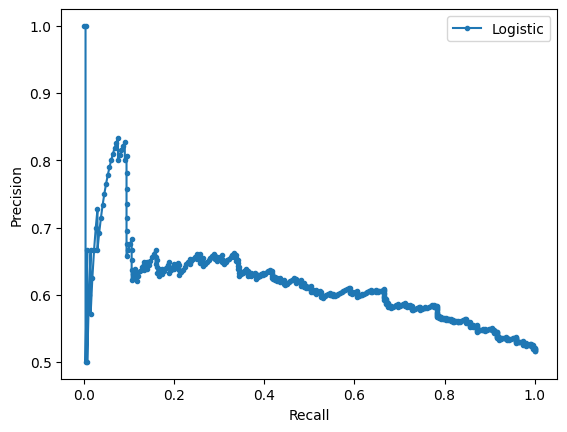

In [22]:
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()

#### Use test data

In [71]:
# import gc
# gc.collect()
del val_df, val_values, val_torch

In [57]:
length = df.shape[0]
val_df = df.iloc[length-page_size:]
val_values = val_df.values
val_torch = torch.tensor(val_values,dtype = torch.float32)

X_val = val_torch[:,:142]
y_val = val_torch[:,142:]
y_val = y_val.bool().any(dim=1,keepdim = True).to(torch.float32)

X_val_combined, y_val_combined = RandomSample(X_val, y_val, 0.5)

y_val_combined = nn.functional.one_hot(y_val_combined.to(torch.int64), num_classes=2)
y_val_combined = y_val_combined.to(torch.float32)

Combined_Dataset = CustomDataset(X_val_combined, y_val_combined)
Combined_DataLoader = DataLoader(Combined_Dataset, batch_size=batch_size, shuffle = True)

model.eval()

output_all = np.asarray([-1])
target_all = np.asarray([-1])
for inputs, targets in tqdm(Combined_DataLoader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs.to(torch.int32))
    output_all = np.concatenate((output_all, outputs[:,1].cpu().detach().numpy()),axis = 0)
    target_all = np.concatenate((target_all, targets[:,1].cpu().detach().numpy()),axis = 0)


222063 222063


  0%|          | 0/434 [00:00<?, ?it/s]

(444126,) (444126,)


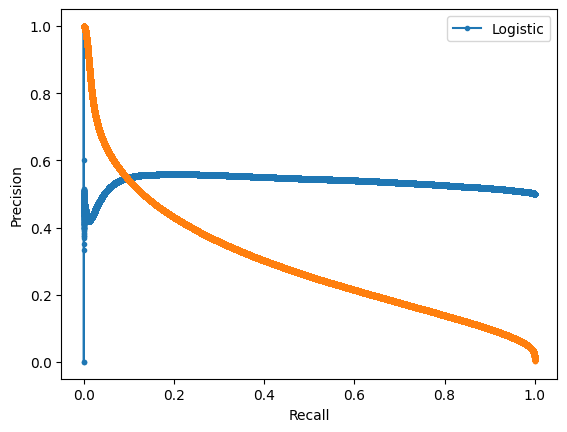

In [61]:
positive_prob = output_all[1:]
target_result = target_all[1:]
print(positive_prob.shape, target_result.shape)
precision, recall, thresholds = precision_recall_curve(target_result, positive_prob)

plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.savefig('./metric_results/run2.png')
plt.plot(recall[1:], thresholds,marker='.', label='Threshold')

### Model Validation

In [92]:
#####
# Validate model performance by using the last page of data. (Never seen by the model)
length = df.shape[0]
val_df = df.iloc[length-page_size:]
val_values = val_df.values
val_torch = torch.tensor(val_values,dtype = torch.float32)

X_val = val_torch[:,:142]
y_val = val_torch[:,142:]
y_val = y_val.bool().any(dim=1,keepdim = True).to(torch.float32)

X_val_combined, y_val_combined = RandomSample(X_val, y_val, 0.5)

y_val_combined = nn.functional.one_hot(y_val_combined.to(torch.int64), num_classes=2)
y_val_combined = y_val_combined.to(torch.float32)

Combined_Dataset = CustomDataset(X_val_combined, y_val_combined)
Combined_DataLoader = DataLoader(Combined_Dataset, batch_size=batch_size, shuffle = True)

model.eval()
accuracy = 0
count = 0
for inputs, targets in tqdm(Combined_DataLoader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs.to(torch.int32))

    predict_class = torch.argmax(outputs,dim=1)
    true_class = torch.argmax(targets,dim=1)
    true_count = (predict_class==true_class).to(torch.float32).sum()    
    res = true_count / batch_size
    # print(res)
    accuracy+=res
    count+=1
    
print(f'Accuracy: {accuracy/count}')

10501 1166


  0%|          | 0/12 [00:00<?, ?it/s]

tensor(0.1606, device='cuda:0')


In [ ]:
from sklearn.metrics import precision_recall_curve


## Generate submission data

In [11]:
df_test = pd.read_parquet(file_path+'test_enc.parquet', engine='pyarrow', columns=None, filters=None)
print(df_test.shape)
df_values = df_test.values
df_test_tensor = torch.tensor(df_values, dtype=torch.float32)

(1674896, 142)


In [12]:
test_csv = pd.read_csv(file_path+'test.csv')

In [ ]:
device = 'cuda'
model = torch.load('model_v1.pth')
test_csv['binds']=0
print(test_csv.head(3))
model.eval()
result = []
batch_size = 4096
for i in range(int(df_test_tensor.shape[0]//batch_size)):
    inputs = df_test_tensor[int(i*batch_size):int((i+1)*batch_size)].view(batch_size,142)
    pred = model(inputs.to(device))
    pred = pred.detach().cpu().numpy()
    pred_score = pred[:,1]# np.argmax(pred, axis=1)
    test_csv.loc[int(i*batch_size):int((i+1)*batch_size)-1,'binds'] = pred_score.flatten()

columns_to_save = ['id', 'binds']  # Replace 'column1' with the actual column name you want to save

# Save the selected columns to a new CSV file
test_csv[columns_to_save].to_csv('sibmission.csv', index=False)

print("New CSV file saved successfully.")